# Notebook 03 — Visualizing Cyclic Group Action (Round-Robin)

This notebook verifies **Claim 3**: round-robin scheduling corresponds to the cyclic subgroup `⟨c⟩ ≅ Z_n` of `S_n`, generated by the `n`-cycle `c = (1 2 ... n)`.

We also touch on **Claim 4** at the end — deadlock as the identity element.

---

**Claim 3 (formal):**  
The round-robin schedule is generated by the `n`-cycle `c = (1 2 ... n)`.  
The cyclic subgroup `⟨c⟩ = { e, c, c², ..., c^(n-1) }` has order `n` and is isomorphic to `Z_n`.

## Setup

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.path.dirname('__file__'), '..', 'src'))

import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
import numpy as np

from permutations import (
    generate_Sn,
    identity,
    cycle_notation_str,
    is_subgroup,
    order as perm_order,
    power,
)
from cyclic_group import (
    make_n_cycle,
    generate_cyclic_subgroup,
    is_transitive,
    is_abelian,
    check_isomorphism_Zn,
    verify_cyclic_subgroup,
    print_cyclic_subgroup,
    print_fraction_of_Sn,
)
from scheduler_model import SchedulerModel

---
## 1. The n-Cycle Generator

The round-robin policy is entirely determined by one permutation — the `n`-cycle `c`.

In [2]:
for n in range(2, 7):
    c = make_n_cycle(n)
    print(f"n={n}:  c = {cycle_notation_str(c):<20}  order = {perm_order(c)}")

n=2:  c = (1 2)                 order = 2
n=3:  c = (1 2 3)               order = 3
n=4:  c = (1 2 3 4)             order = 4
n=5:  c = (1 2 3 4 5)           order = 5
n=6:  c = (1 2 3 4 5 6)         order = 6


---
## 2. Generating ⟨c⟩

Repeated composition of `c` with itself generates all `n` round-robin schedules.

In [3]:
print_cyclic_subgroup(n=4)
print()
print_cyclic_subgroup(n=5)


Round-robin schedules for 4 processes  —  ⟨c⟩ ≅ Z_4:

  c^0 = e                     →  queue [1, 2, 3, 4]
  c^1 = (1 2 3 4)             →  queue [2, 3, 4, 1]
  c^2 = (1 3)(2 4)            →  queue [3, 4, 1, 2]
  c^3 = (1 4 3 2)             →  queue [4, 1, 2, 3]


Round-robin schedules for 5 processes  —  ⟨c⟩ ≅ Z_5:

  c^0 = e                     →  queue [1, 2, 3, 4, 5]
  c^1 = (1 2 3 4 5)           →  queue [2, 3, 4, 5, 1]
  c^2 = (1 3 5 2 4)           →  queue [3, 4, 5, 1, 2]
  c^3 = (1 4 2 5 3)           →  queue [4, 5, 1, 2, 3]
  c^4 = (1 5 4 3 2)           →  queue [5, 1, 2, 3, 4]


---
## 3. Visualizing the Cyclic Action — Process Rotation

Each application of `c` rotates the process queue by one step. 
We visualize this as points on a circle — the natural geometry of `Z_n`.

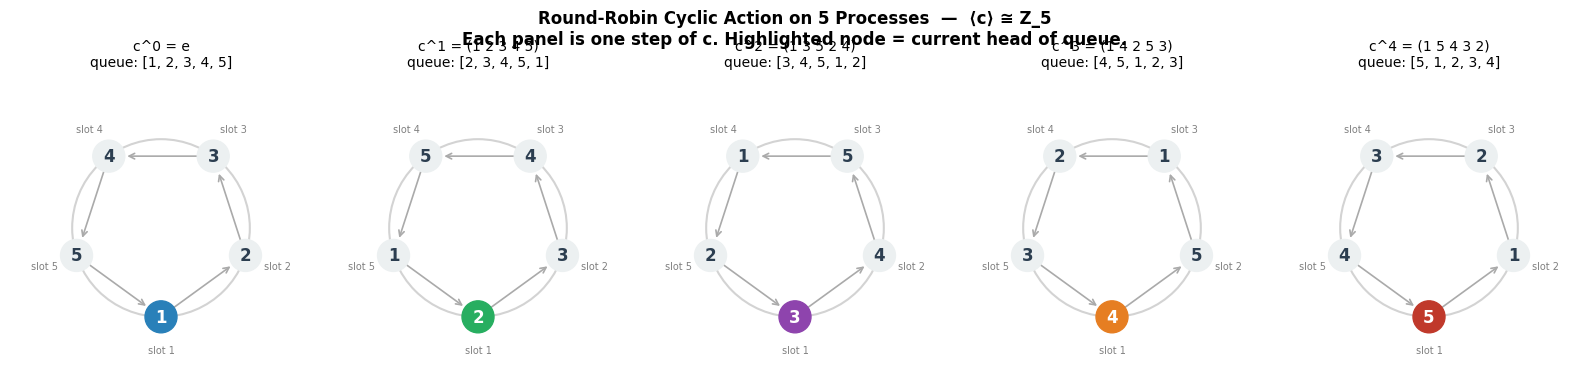

In [4]:
def draw_cycle(ax, n, step, color='steelblue'):
    """Draw the process queue after k=step applications of c on a unit circle."""
    c       = make_n_cycle(n)
    sigma   = power(c, step)
    queue   = list(sigma.values())
    angles  = [2 * math.pi * i / n - math.pi / 2 for i in range(n)]

    # Draw circle
    circle = plt.Circle((0, 0), 1, fill=False, color='lightgrey', linewidth=1.5)
    ax.add_patch(circle)

    # Draw arrows for the cycle
    for i in range(n):
        x1, y1 = math.cos(angles[i]),         math.sin(angles[i])
        x2, y2 = math.cos(angles[(i+1) % n]), math.sin(angles[(i+1) % n])
        dx, dy = (x2 - x1) * 0.85, (y2 - y1) * 0.85
        ax.annotate('', xy=(x1 + dx, y1 + dy), xytext=(x1 + dx*0.1, y1 + dy*0.1),
                    arrowprops=dict(arrowstyle='->', color='#aaaaaa', lw=1.2))

    # Draw process nodes
    for i, proc in enumerate(queue):
        x, y = math.cos(angles[i]), math.sin(angles[i])
        slot_color = color if i == 0 else '#ecf0f1'
        txt_color  = 'white' if i == 0 else '#2c3e50'
        ax.add_patch(plt.Circle((x, y), 0.18, color=slot_color, zorder=3))
        ax.text(x, y, str(proc), ha='center', va='center',
                fontsize=12, fontweight='bold', color=txt_color, zorder=4)
        ax.text(x * 1.38, y * 1.38, f'slot {i+1}',
                ha='center', va='center', fontsize=7, color='grey')

    ax.set_xlim(-1.7, 1.7)
    ax.set_ylim(-1.7, 1.7)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'c^{step} = {cycle_notation_str(sigma)}\nqueue: {queue}',
                 fontsize=10, pad=8)


n   = 5
fig, axes = plt.subplots(1, n, figsize=(16, 4))

shades = ['#2980b9', '#27ae60', '#8e44ad', '#e67e22', '#c0392b']

for k, ax in enumerate(axes):
    draw_cycle(ax, n=n, step=k, color=shades[k])

plt.suptitle(f'Round-Robin Cyclic Action on {n} Processes  —  ⟨c⟩ ≅ Z_{n}\n'
             'Each panel is one step of c. Highlighted node = current head of queue.',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../notebooks/cyclic_action.png', dpi=130, bbox_inches='tight')
plt.show()

---
## 4. ⟨c⟩ as a Fraction of S_n

Round-robin is a very small subgroup of the full scheduling space. This shrinks rapidly as `n` grows.

n     |⟨c⟩|    |S_n|      % of S_n
-----------------------------------
2     2        2          100.0000%
3     3        6          50.0000%
4     4        24         16.6667%
5     5        120        4.1667%
6     6        720        0.8333%
7     7        5040       0.1389%
8     8        40320      0.0198%


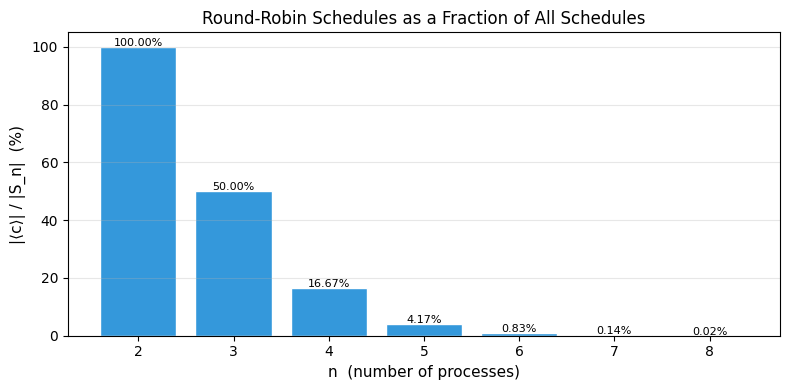

In [5]:
ns          = list(range(2, 9))
sn_sizes    = [math.factorial(n) for n in ns]
cyc_sizes   = ns
fractions   = [c / s * 100 for c, s in zip(cyc_sizes, sn_sizes)]

print(f"{'n':<5} {'|⟨c⟩|':<8} {'|S_n|':<10} {'% of S_n'}")
print("-" * 35)
for n, c, s, f in zip(ns, cyc_sizes, sn_sizes, fractions):
    print(f"{n:<5} {c:<8} {s:<10} {f:.4f}%")

# Plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(ns, fractions, color='#3498db', edgecolor='white')
ax.set_xlabel('n  (number of processes)', fontsize=11)
ax.set_ylabel('|⟨c⟩| / |S_n|  (%)', fontsize=11)
ax.set_title('Round-Robin Schedules as a Fraction of All Schedules', fontsize=12)
ax.set_xticks(ns)
ax.grid(axis='y', alpha=0.3)

for i, (n, f) in enumerate(zip(ns, fractions)):
    ax.text(n, f + 0.3, f'{f:.2f}%', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('../notebooks/cyclic_fraction.png', dpi=120, bbox_inches='tight')
plt.show()

---
## 5. Transitivity — Starvation Freedom

The action of `⟨c⟩` on `P` is transitive: every process can reach every other process position. This is the algebraic statement of starvation freedom.

In [6]:
print("Transitivity of ⟨c⟩ action on P:\n")
print(f"  {'n':<5} {'Transitive':<15} {'Interpretation'}")
print("  " + "-" * 45)

for n in range(2, 7):
    cyclic = generate_cyclic_subgroup(n)
    trans  = is_transitive(cyclic, n)
    interp = "Every process reaches every slot  ✓" if trans else "Some process is stranded  ✗"
    print(f"  {n:<5} {'yes' if trans else 'no':<15} {interp}")

Transitivity of ⟨c⟩ action on P:

  n     Transitive      Interpretation
  ---------------------------------------------
  2     yes             Every process reaches every slot  ✓
  3     yes             Every process reaches every slot  ✓
  4     yes             Every process reaches every slot  ✓
  5     yes             Every process reaches every slot  ✓
  6     yes             Every process reaches every slot  ✓


---
## 6. Isomorphism with Z_n

Verify the homomorphism `φ: Z_n → ⟨c⟩`, `φ(k) = c^k` is a group isomorphism.

In [7]:
print("Isomorphism ⟨c⟩ ≅ Z_n:\n")
for n in range(2, 7):
    cyclic = generate_cyclic_subgroup(n)
    iso    = check_isomorphism_Zn(cyclic, n)
    print(f"  n={n}:  ⟨c⟩ ≅ Z_{n}  {'✓' if iso else '✗'}")

Isomorphism ⟨c⟩ ≅ Z_n:

  n=2:  ⟨c⟩ ≅ Z_2  ✓
  n=3:  ⟨c⟩ ≅ Z_3  ✓
  n=4:  ⟨c⟩ ≅ Z_4  ✓
  n=5:  ⟨c⟩ ≅ Z_5  ✓
  n=6:  ⟨c⟩ ≅ Z_6  ✓


---
## 7. Claim 4 — Deadlock as the Identity

Deadlock is the state where no process advances. The only permutation consistent with this is `e`.

We verify `e` is the unique element of `S_n` satisfying `σ(i) = i` for all `i`.

In [8]:
print("Deadlock verification — unique identity in S_n:\n")
print(f"  {'n':<5} {'Fixed-point permutations':<28} {'Count':<8} {'Check'}")
print("  " + "-" * 50)

for n in range(2, 7):
    Sn    = generate_Sn(n)
    e     = identity(n)
    fixed = [s for s in Sn if all(s[i] == i for i in range(1, n+1))]
    ok    = "✓" if len(fixed) == 1 and fixed[0] == e else "✗"
    elems = ", ".join(cycle_notation_str(s) for s in fixed)
    print(f"  {n:<5} {elems:<28} {len(fixed):<8} {ok}")

print("\n  In every S_n, the identity e is the unique deadlock state.")

Deadlock verification — unique identity in S_n:

  n     Fixed-point permutations     Count    Check
  --------------------------------------------------
  2     e                            1        ✓
  3     e                            1        ✓
  4     e                            1        ✓
  5     e                            1        ✓
  6     e                            1        ✓

  In every S_n, the identity e is the unique deadlock state.


---
## 8. Full Classification for S_3

Classify every element of `S_3` by all four claims simultaneously.

In [9]:
model = SchedulerModel(n=3)
model.print_classification_table()


Classification of all schedules in S_3:

  Permutation          Deadlock     Mutex        Round-Robin
  ------------------ ---------- ---------- -----------
  e                    yes          yes          yes
  (2 3)                -            yes          -
  (1 2)                -            -            -
  (1 2 3)              -            -            yes
  (1 3 2)              -            -            yes
  (1 3)                -            -            -


---
## 9. Full Verification Suite

Run all verifications across `n = 2` to `6`.

In [10]:
all_passed = True
for n in range(2, 7):
    passed     = verify_cyclic_subgroup(n, verbose=True)
    all_passed = all_passed and passed

print(f"\n{'All verifications passed ✓' if all_passed else 'Some verifications FAILED ✗'}")


Cyclic Subgroup Verification  —  n = 2
  [✓] ⟨c⟩ is a subgroup of S_2
  [✓] |⟨c⟩| = 2  (expected 2)
  [✓] c^2 = e  →  e
  [✓] ⟨c⟩ ≅ Z_2  (homomorphism verified)
  [✓] Action on P is transitive  (starvation-free)
  [✓] ⟨c⟩ is abelian

Cyclic Subgroup Verification  —  n = 3
  [✓] ⟨c⟩ is a subgroup of S_3
  [✓] |⟨c⟩| = 3  (expected 3)
  [✓] c^3 = e  →  e
  [✓] ⟨c⟩ ≅ Z_3  (homomorphism verified)
  [✓] Action on P is transitive  (starvation-free)
  [✓] ⟨c⟩ is abelian

Cyclic Subgroup Verification  —  n = 4
  [✓] ⟨c⟩ is a subgroup of S_4
  [✓] |⟨c⟩| = 4  (expected 4)
  [✓] c^4 = e  →  e
  [✓] ⟨c⟩ ≅ Z_4  (homomorphism verified)
  [✓] Action on P is transitive  (starvation-free)
  [✓] ⟨c⟩ is abelian

Cyclic Subgroup Verification  —  n = 5
  [✓] ⟨c⟩ is a subgroup of S_5
  [✓] |⟨c⟩| = 5  (expected 5)
  [✓] c^5 = e  →  e
  [✓] ⟨c⟩ ≅ Z_5  (homomorphism verified)
  [✓] Action on P is transitive  (starvation-free)
  [✓] ⟨c⟩ is abelian

Cyclic Subgroup Verification  —  n = 6
  [✓] ⟨c⟩ is a subgroup 

---
## 10. Subgroup Lattice — All Four Claims Together

A visual summary of the subgroup relationships across all four claims.

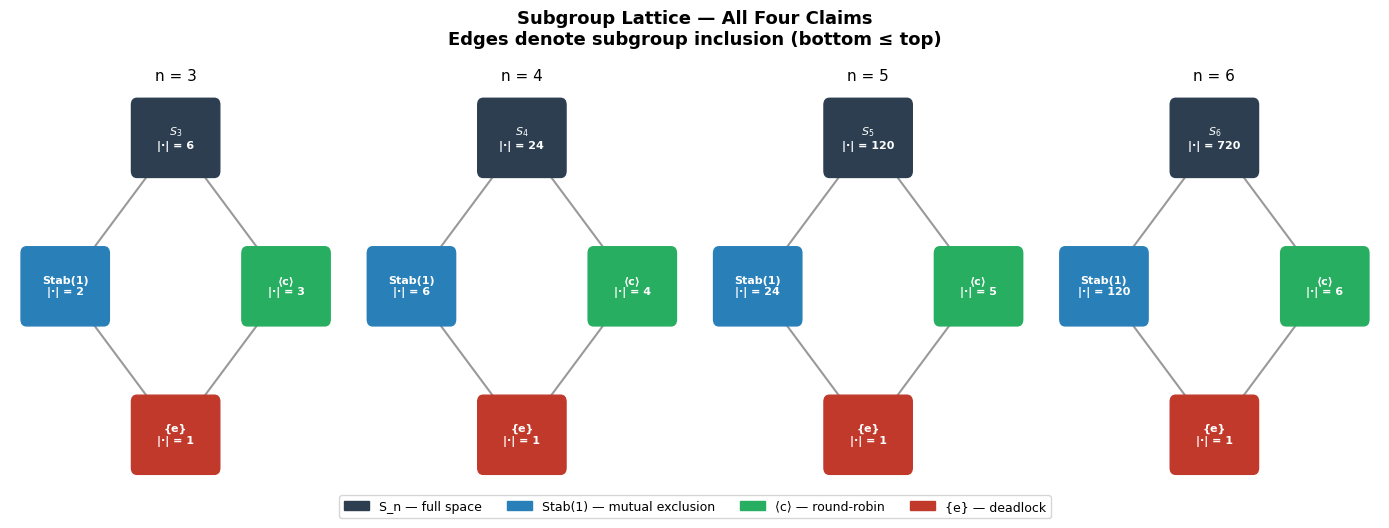

In [11]:
def draw_lattice(ax, n):
    sn_order   = math.factorial(n)
    stab_order = math.factorial(n - 1)
    cyc_order  = n

    nodes = {
        'Sn'   : (0.5, 1.0,  f'$S_{n}$\n|·| = {sn_order}',   '#2c3e50', 'white'),
        'stab' : (0.1, 0.55, f'Stab(1)\n|·| = {stab_order}', '#2980b9', 'white'),
        'cyc'  : (0.9, 0.55, f'⟨c⟩\n|·| = {cyc_order}',      '#27ae60', 'white'),
        'e'    : (0.5, 0.1,  f'{{e}}\n|·| = 1',               '#c0392b', 'white'),
    }

    edges = [('Sn', 'stab'), ('Sn', 'cyc'), ('stab', 'e'), ('cyc', 'e')]

    pos = {k: (v[0], v[1]) for k, v in nodes.items()}

    for a, b in edges:
        x1, y1 = pos[a]
        x2, y2 = pos[b]
        ax.plot([x1, x2], [y1, y2], 'k-', lw=1.5, alpha=0.4, zorder=1)

    for key, (x, y, label, color, tcolor) in nodes.items():
        ax.add_patch(mpatches.FancyBboxPatch(
            (x - 0.14, y - 0.1), 0.28, 0.2,
            boxstyle='round,pad=0.02', color=color, zorder=2
        ))
        ax.text(x, y, label, ha='center', va='center',
                fontsize=8, color=tcolor, fontweight='bold', zorder=3)

    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.05, 1.15)
    ax.set_title(f'n = {n}', fontsize=11)
    ax.axis('off')


fig, axes = plt.subplots(1, 4, figsize=(14, 5))

for ax, n in zip(axes, range(3, 7)):
    draw_lattice(ax, n)

labels = [
    mpatches.Patch(color='#2c3e50', label='S_n — full space'),
    mpatches.Patch(color='#2980b9', label='Stab(1) — mutual exclusion'),
    mpatches.Patch(color='#27ae60', label='⟨c⟩ — round-robin'),
    mpatches.Patch(color='#c0392b', label='{e} — deadlock'),
]
fig.legend(handles=labels, loc='lower center', ncol=4, fontsize=9,
           bbox_to_anchor=(0.5, -0.05))

plt.suptitle('Subgroup Lattice — All Four Claims\n'
             'Edges denote subgroup inclusion (bottom ≤ top)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('../notebooks/subgroup_lattice.png', dpi=130, bbox_inches='tight')
plt.show()

---
## 11. Summary
Claims 3 and 4 verified.

Round-robin is the cyclic subgroup `⟨c⟩ ≅ Z_n` — abelian, transitive, and of order `n`.  
Deadlock is the unique identity element `e ∈ S_n` — the most degenerate point in the scheduling space.

---

*All four claims of the project are now computationally verified.*  
*See `paper/draft.tex` for the written exposition.*